In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics as skm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
df_iad = pd.read_csv("../data/classification/final_IADSED.csv")
df_emo = pd.read_csv("../data/classification/final_EmoSounds.csv")

In [3]:
"""
  Load target features on y and drop target features on X.
  Perform shuffle on first split to prevent bias. Split 80-20 for train-test.
  Split again on train to get validation set. So 60-20-20.
"""
def train_test_valid_split(df, targets):
  y = df[targets]
  X = df.drop(targets, axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state=101)

  return X_train, X_test, X_val, y_train, y_test, y_val

In [4]:
"""
  Creates random forest classifer instance with default hyperparameters.
  If classifer_cv is provided, then use the best hyperparameters from grid search results.
  
  If asked to do dataset balancing, run SMOTE (Oversampling Method) to increase the number of minority class samples for balanced class distribution.

  If asked to do grid search and parameter grid is provided, then we will perform grid search to find the best parameters. 
  After grid search is complete, print the best parameters.

  Otherwise, train the model with our training data.
"""
def RFClassifer(X_train, y_train, grid_search=False, param_grid=None, classifer_cv=None, ds_balancing=False, ds_name="NA"):

  if classifer_cv == None:
    classifer = RandomForestClassifier(random_state=101)
  else:
    classifer = RandomForestClassifier(random_state=101, **classifer_cv.best_params_)

  if ds_balancing == True:
    classifer = Pipeline([
      ('ds_balancing', SMOTE(random_state=101)),
      ('rf_classification', classifer)
    ])    

  if grid_search == True and not param_grid == None:
    
    if ds_balancing:
      classifer = classifer["rf_classification"]

    classifer_gs = GridSearchCV(classifer, param_grid, cv=5, n_jobs=-1)
    classifer_gs.fit(X_train, y_train)
    print(f"{ds_name} - Best Parameters:", classifer_gs.best_params_)

    return classifer_gs
  else:
    classifer.fit(X_train, y_train)

  return classifer

In [5]:
"""
  Predicts emotion type with the test or validation set.
  Prints the classification report containing the precision, recall, and f1-score of each emotion type and the overall accuracy.
  Also generates a confusion matrix of these emotions types.
"""
def RFPredictions(classifer, X_test, y_test, ds_type, ds_name):
  y_pred = classifer.predict(X_test)

  print(f'{ds_name} - {ds_type} Classification Report')#
  print(classification_report(y_test, y_pred))  

  conf_matrix = confusion_matrix(y_test, y_pred)

  classes = y_test.unique().tolist()

  plt.figure(figsize=(4, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd', cbar=False, 
              xticklabels=classes, yticklabels=classes)

  plt.title(f'{ds_name} {ds_type} Confusion Matrix')
  plt.xlabel('Predicted Classes')
  plt.ylabel('True Classes')
  plt.show()  

In [6]:
"""
  Merges training and validation data, since we are now performing K-Fold CV.
"""
def concat_train_valid(X_train, y_train, X_val, y_val):
  X_train = pd.concat([X_train, X_val])
  y_train = pd.concat([y_train, y_val])

  return X_train, y_train

In [7]:
"""
    Perform Feature Selection via feature importance functionality from Random Forest Regressor.
    It will get the top k (10 by default) features of the model and return the training, test, and validation datasets with only those said features selected.
"""
def select_top_k(classifer, X_train, X_test, X_val, top_k=10):

    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': classifer.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    top_features = feature_importance['Feature'][:top_k].values

    X_train = X_train[top_features]
    X_test = X_test[top_features]
    X_val = X_val[top_features]

    return X_train, X_test, X_val

In [8]:
"""
    TBA
"""
def RFClassification(df, grid_search=False, feature_selection=False, ds_balancing=False, param_grid=None, ds_name=""):
    X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid_split(df, "emotion_types")

    if feature_selection == True:
        classifer = RFClassifer(X_train=X_train, y_train=y_train)
        X_train, X_test, X_val = select_top_k(classifer=classifer, X_train=X_train, X_test=X_test, X_val=X_val, top_k=20)

    if grid_search == True and not param_grid == None:   
        X_train, y_train = concat_train_valid(X_train, y_train, X_val, y_val)

        classifer_cv = RFClassifer(X_train=X_train, y_train=y_train, grid_search=True, param_grid=param_grid, ds_balancing=ds_balancing, ds_name=ds_name) 

        classifer_best = RFClassifer(X_train, y_train, classifer_cv=classifer_cv)

        RFPredictions(classifer=classifer_best, X_test=X_test, y_test=y_test, ds_type="Test", ds_name=ds_name)  

        return
    else:
        classifer = RFClassifer(X_train=X_train, y_train=y_train, ds_balancing=ds_balancing)

        RFPredictions(classifer=classifer, X_test=X_val, y_test=y_val, ds_type="Validation", ds_name=ds_name)
        RFPredictions(classifer=classifer, X_test=X_test, y_test=y_test, ds_type="Test", ds_name=ds_name)
        
        return

In [9]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'bootstrap': [True]
}

# Hold Out Method (No Feature Selection and No Dataset Balancing)

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.44      0.14      0.21        29
Negative Arousal, Positive Valence       0.67      0.64      0.65        22
Positive Arousal, Negative Valence       0.67      0.94      0.78        70
Positive Arousal, Positive Valence       0.90      0.64      0.75        28

                          accuracy                           0.68       149
                         macro avg       0.67      0.59      0.60       149
                      weighted avg       0.67      0.68      0.65       149



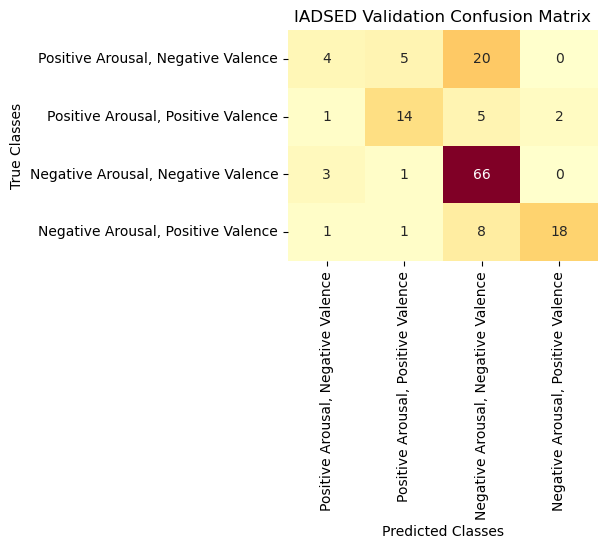

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.09      0.14        22
Negative Arousal, Positive Valence       0.65      0.44      0.53        34
Positive Arousal, Negative Valence       0.73      0.94      0.82        99
Positive Arousal, Positive Valence       0.59      0.55      0.57        31

                          accuracy                           0.68       186
                         macro avg       0.57      0.50      0.51       186
                      weighted avg       0.64      0.68      0.64       186



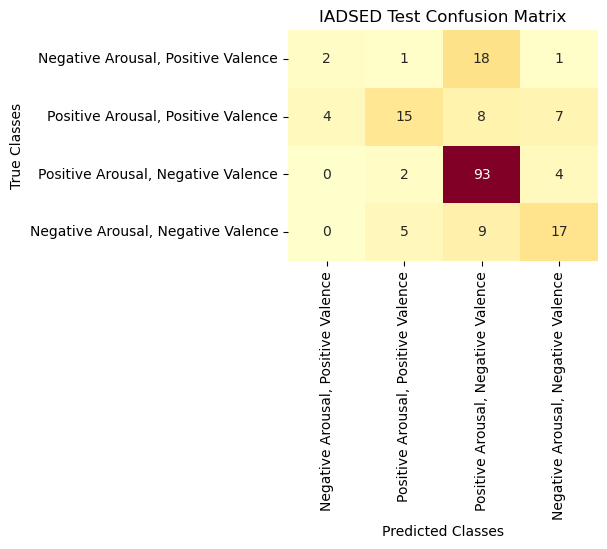

In [10]:
RFClassification(df_iad, ds_name="IADSED")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.38      0.18      0.24        17
Negative Arousal, Positive Valence       0.73      0.84      0.78        32
Positive Arousal, Negative Valence       0.72      0.97      0.83        37
Positive Arousal, Positive Valence       1.00      0.10      0.18        10

                          accuracy                           0.70        96
                         macro avg       0.71      0.52      0.51        96
                      weighted avg       0.69      0.70      0.64        96



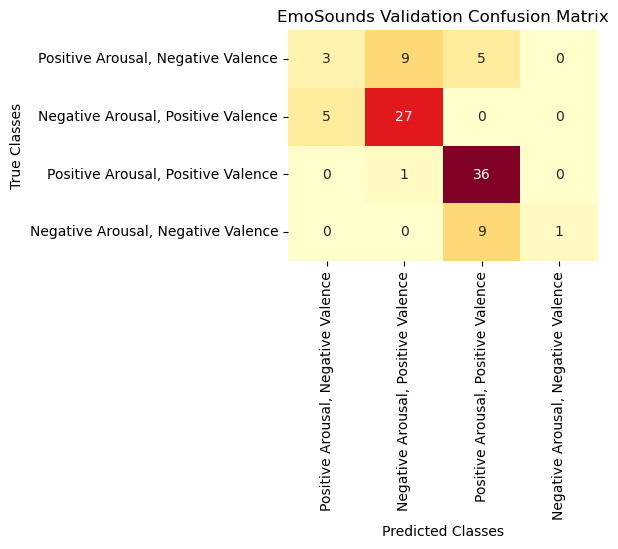

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.43      0.13      0.20        23
Negative Arousal, Positive Valence       0.62      0.86      0.72        37
Positive Arousal, Negative Valence       0.77      0.81      0.79        54
Positive Arousal, Positive Valence       0.25      0.17      0.20         6

                          accuracy                           0.67       120
                         macro avg       0.52      0.49      0.48       120
                      weighted avg       0.63      0.67      0.63       120



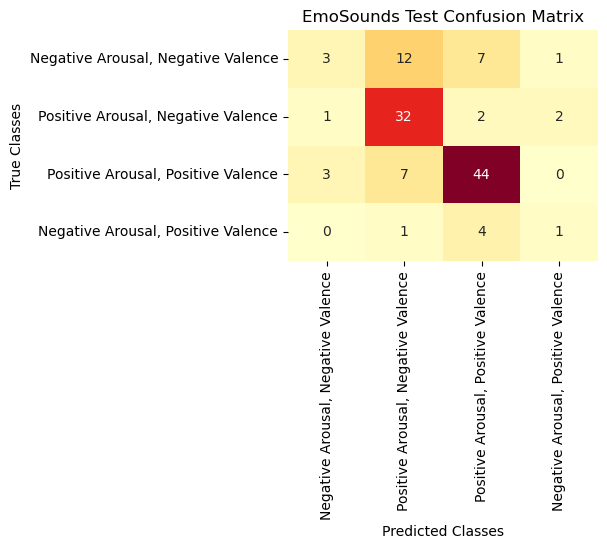

In [11]:
RFClassification(df_emo, ds_name="EmoSounds")

# Hold Out Method (Feature Selection only)

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.58      0.24      0.34        29
Negative Arousal, Positive Valence       0.67      0.64      0.65        22
Positive Arousal, Negative Valence       0.72      0.91      0.81        70
Positive Arousal, Positive Valence       0.74      0.71      0.73        28

                          accuracy                           0.70       149
                         macro avg       0.68      0.63      0.63       149
                      weighted avg       0.69      0.70      0.68       149



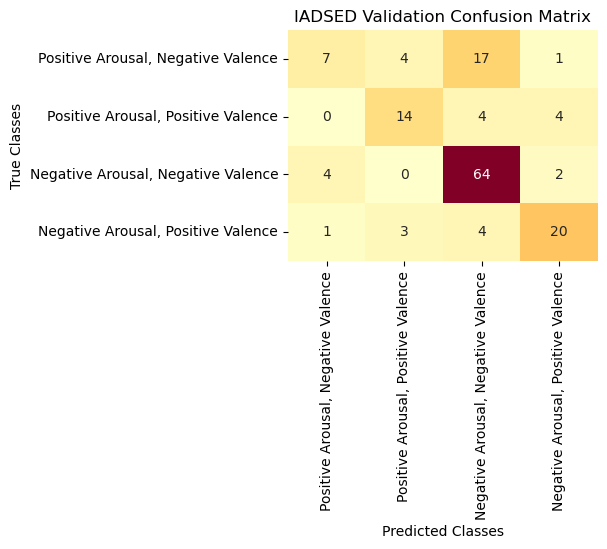

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.23      0.27        22
Negative Arousal, Positive Valence       0.62      0.47      0.53        34
Positive Arousal, Negative Valence       0.79      0.90      0.84        99
Positive Arousal, Positive Valence       0.56      0.58      0.57        31

                          accuracy                           0.69       186
                         macro avg       0.57      0.54      0.55       186
                      weighted avg       0.66      0.69      0.67       186



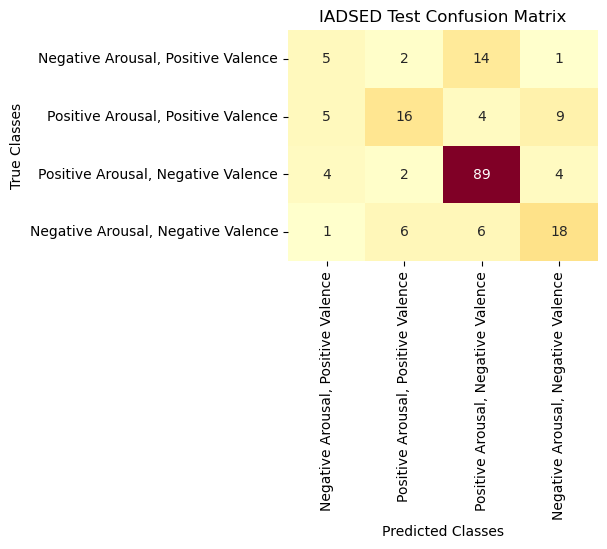

In [12]:
RFClassification(df_iad, feature_selection=True, ds_name="IADSED")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.44      0.24      0.31        17
Negative Arousal, Positive Valence       0.73      0.94      0.82        32
Positive Arousal, Negative Valence       0.79      0.89      0.84        37
Positive Arousal, Positive Valence       0.75      0.30      0.43        10

                          accuracy                           0.73        96
                         macro avg       0.68      0.59      0.60        96
                      weighted avg       0.70      0.73      0.70        96



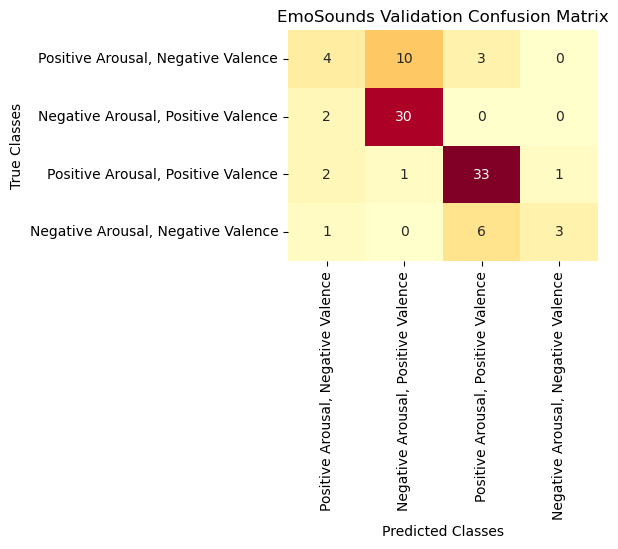

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.22      0.30        23
Negative Arousal, Positive Valence       0.60      0.86      0.71        37
Positive Arousal, Negative Valence       0.79      0.78      0.79        54
Positive Arousal, Positive Valence       0.00      0.00      0.00         6

                          accuracy                           0.66       120
                         macro avg       0.47      0.47      0.45       120
                      weighted avg       0.64      0.66      0.63       120



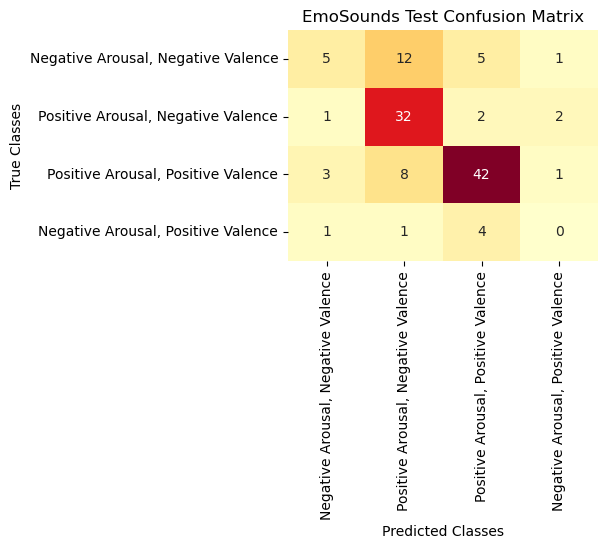

In [13]:
RFClassification(df_emo, feature_selection=True, ds_name="EmoSounds")

# Hold Out Method (Dataset Balancing only)

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.36      0.28      0.31        29
Negative Arousal, Positive Valence       0.67      0.73      0.70        22
Positive Arousal, Negative Valence       0.73      0.83      0.78        70
Positive Arousal, Positive Valence       0.88      0.75      0.81        28

                          accuracy                           0.69       149
                         macro avg       0.66      0.65      0.65       149
                      weighted avg       0.68      0.69      0.68       149



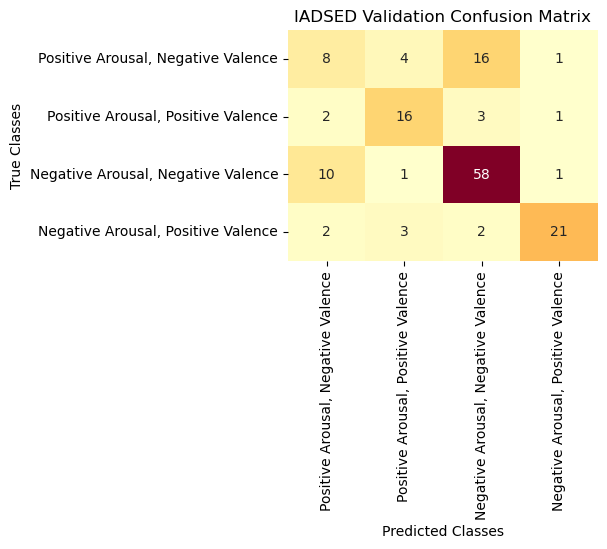

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.39      0.32      0.35        22
Negative Arousal, Positive Valence       0.64      0.47      0.54        34
Positive Arousal, Negative Valence       0.76      0.85      0.80        99
Positive Arousal, Positive Valence       0.56      0.58      0.57        31

                          accuracy                           0.67       186
                         macro avg       0.59      0.55      0.57       186
                      weighted avg       0.66      0.67      0.66       186



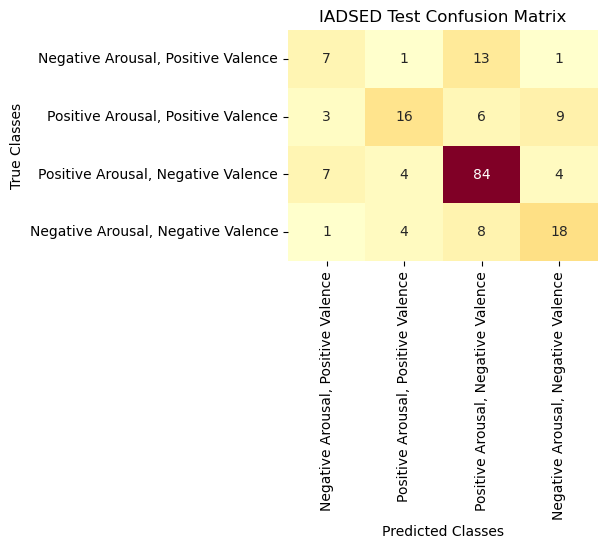

In [14]:
RFClassification(df_iad, ds_balancing=True, ds_name="IADSED")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.43      0.35      0.39        17
Negative Arousal, Positive Valence       0.72      0.81      0.76        32
Positive Arousal, Negative Valence       0.84      0.84      0.84        37
Positive Arousal, Positive Valence       0.67      0.60      0.63        10

                          accuracy                           0.72        96
                         macro avg       0.66      0.65      0.66        96
                      weighted avg       0.71      0.72      0.71        96



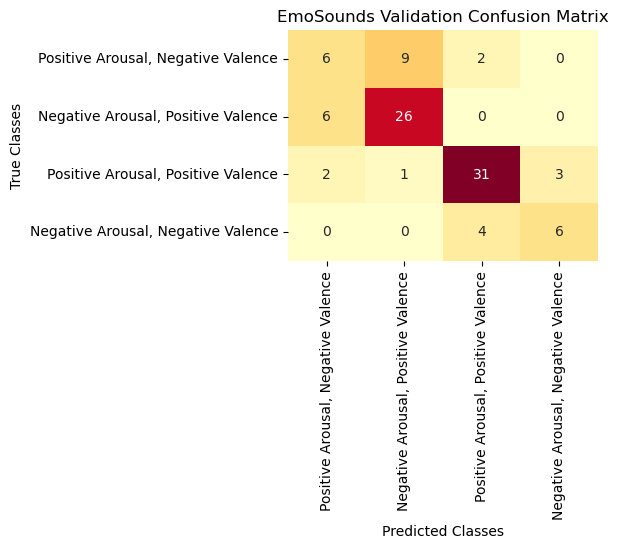

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.35      0.41        23
Negative Arousal, Positive Valence       0.70      0.86      0.77        37
Positive Arousal, Negative Valence       0.82      0.74      0.78        54
Positive Arousal, Positive Valence       0.11      0.17      0.13         6

                          accuracy                           0.68       120
                         macro avg       0.53      0.53      0.52       120
                      weighted avg       0.68      0.68      0.67       120



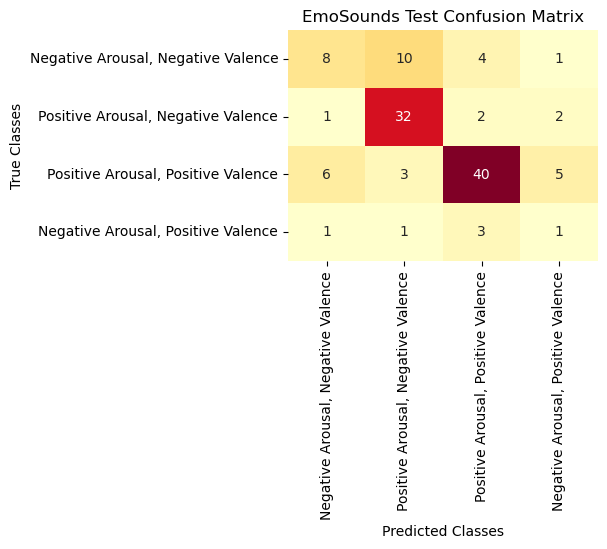

In [15]:
RFClassification(df_emo, ds_balancing=True, ds_name="EmoSounds")

# Hold Out Method (Feature Selection and Dataset Balancing)

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.54      0.48      0.51        29
Negative Arousal, Positive Valence       0.68      0.68      0.68        22
Positive Arousal, Negative Valence       0.76      0.81      0.79        70
Positive Arousal, Positive Valence       0.77      0.71      0.74        28

                          accuracy                           0.71       149
                         macro avg       0.69      0.67      0.68       149
                      weighted avg       0.71      0.71      0.71       149



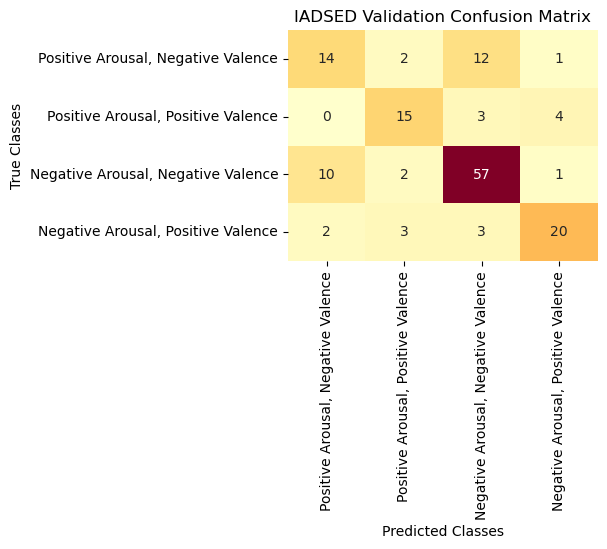

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.32      0.41      0.36        22
Negative Arousal, Positive Valence       0.56      0.44      0.49        34
Positive Arousal, Negative Valence       0.81      0.80      0.80        99
Positive Arousal, Positive Valence       0.58      0.61      0.59        31

                          accuracy                           0.66       186
                         macro avg       0.56      0.57      0.56       186
                      weighted avg       0.66      0.66      0.66       186



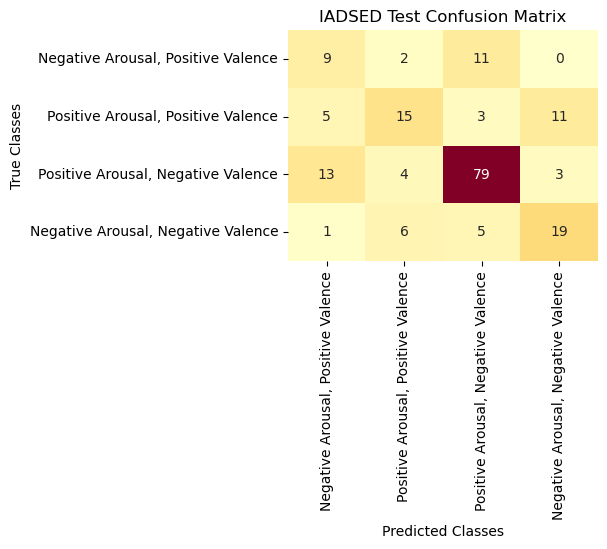

In [16]:
RFClassification(df_iad, feature_selection=True, ds_balancing=True, ds_name="IADSED")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.42      0.47      0.44        17
Negative Arousal, Positive Valence       0.81      0.78      0.79        32
Positive Arousal, Negative Valence       0.81      0.78      0.79        37
Positive Arousal, Positive Valence       0.40      0.40      0.40        10

                          accuracy                           0.69        96
                         macro avg       0.61      0.61      0.61        96
                      weighted avg       0.70      0.69      0.69        96



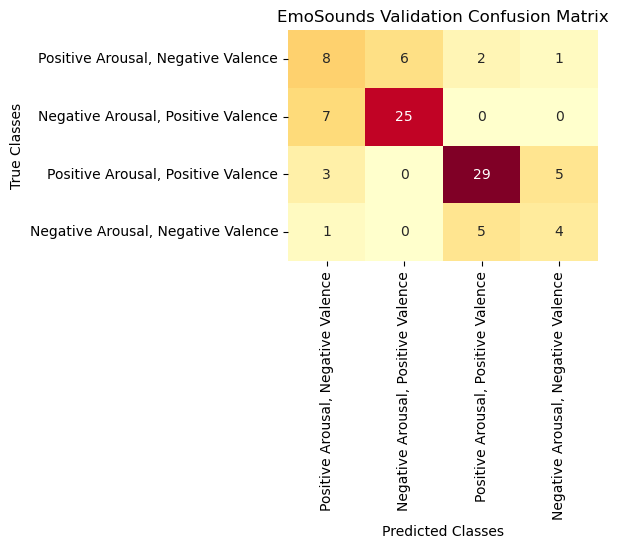

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.43      0.39      0.41        23
Negative Arousal, Positive Valence       0.70      0.76      0.73        37
Positive Arousal, Negative Valence       0.80      0.72      0.76        54
Positive Arousal, Positive Valence       0.10      0.17      0.12         6

                          accuracy                           0.64       120
                         macro avg       0.51      0.51      0.50       120
                      weighted avg       0.66      0.64      0.65       120



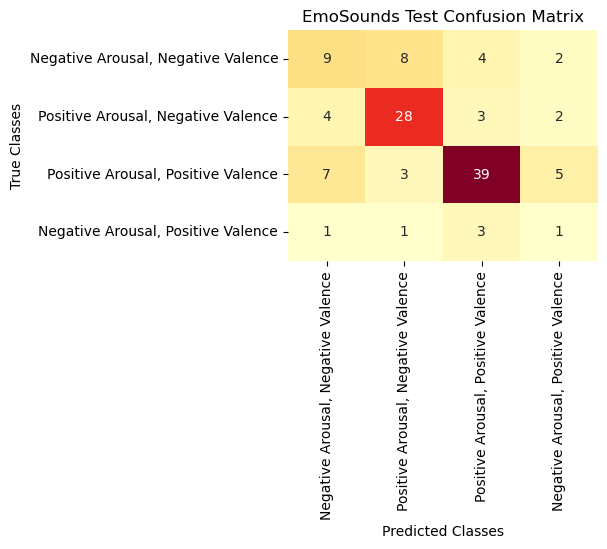

In [17]:
RFClassification(df_emo, feature_selection=True, ds_balancing=True, ds_name="EmoSounds")

# Grid Search CV (No Feature Selection and No Dataset Balancing)

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.29      0.27      0.28        22
Negative Arousal, Positive Valence       0.57      0.47      0.52        34
Positive Arousal, Negative Valence       0.78      0.79      0.78        99
Positive Arousal, Positive Valence       0.57      0.68      0.62        31

                          accuracy                           0.65       186
                         macro avg       0.55      0.55      0.55       186
                      weighted avg       0.65      0.65      0.65       186



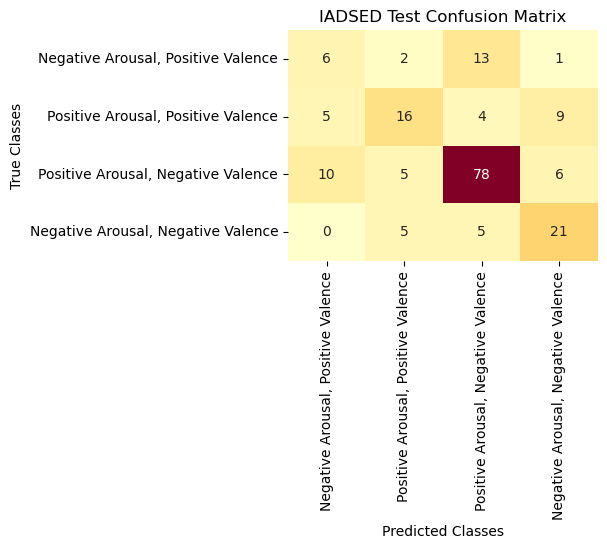

In [18]:
RFClassification(df_iad, grid_search=True, param_grid=param_grid, ds_name="IADSED")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.13      0.21        23
Negative Arousal, Positive Valence       0.62      0.92      0.74        37
Positive Arousal, Negative Valence       0.76      0.81      0.79        54
Positive Arousal, Positive Valence       1.00      0.17      0.29         6

                          accuracy                           0.68       120
                         macro avg       0.72      0.51      0.50       120
                      weighted avg       0.68      0.68      0.64       120



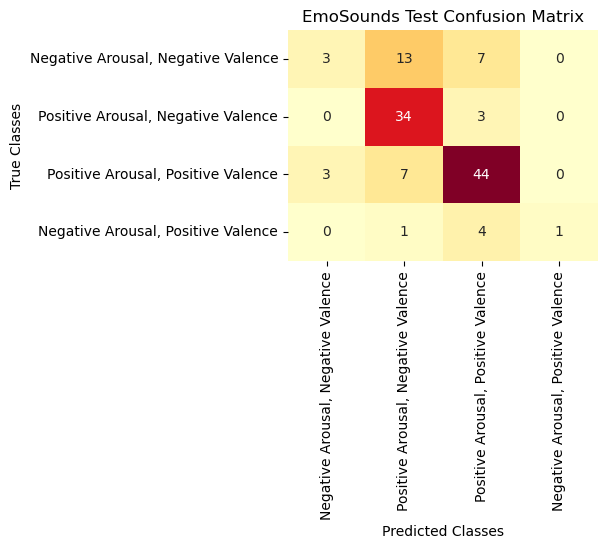

In [19]:
RFClassification(df_emo, grid_search=True, param_grid=param_grid, ds_name="EmoSounds")

# Grid Search CV (Feature Selection Only)

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.27      0.30        22
Negative Arousal, Positive Valence       0.70      0.47      0.56        34
Positive Arousal, Negative Valence       0.79      0.86      0.83        99
Positive Arousal, Positive Valence       0.55      0.68      0.61        31

                          accuracy                           0.69       186
                         macro avg       0.59      0.57      0.57       186
                      weighted avg       0.68      0.69      0.68       186



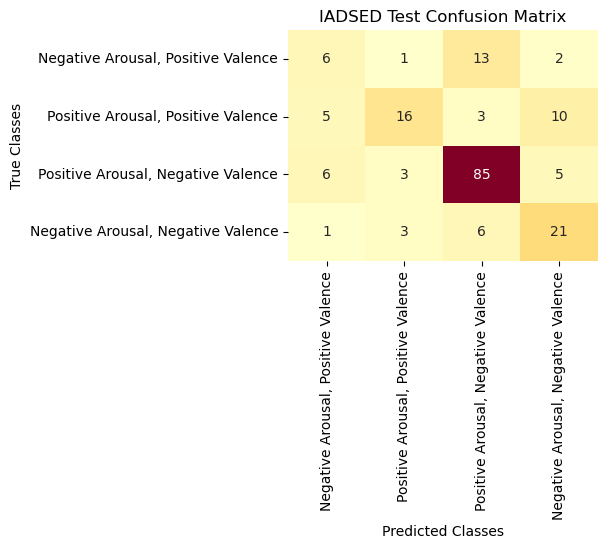

In [20]:
RFClassification(df_iad, grid_search=True, param_grid=param_grid, feature_selection=True, ds_name="IADSED")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.78      0.30      0.44        23
Negative Arousal, Positive Valence       0.60      0.81      0.69        37
Positive Arousal, Negative Valence       0.79      0.76      0.77        54
Positive Arousal, Positive Valence       0.11      0.17      0.13         6

                          accuracy                           0.66       120
                         macro avg       0.57      0.51      0.51       120
                      weighted avg       0.69      0.66      0.65       120



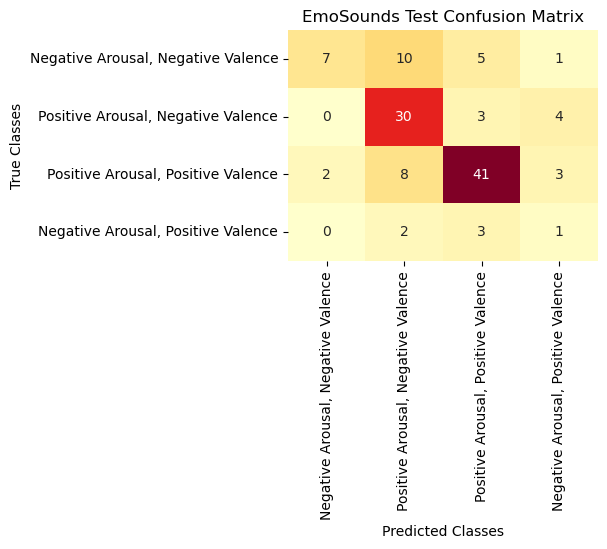

In [21]:
RFClassification(df_emo, grid_search=True, param_grid=param_grid, feature_selection=True, ds_name="EmoSounds")

# Grid Search CV (Dataset Balancing Only)

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.29      0.27      0.28        22
Negative Arousal, Positive Valence       0.57      0.47      0.52        34
Positive Arousal, Negative Valence       0.78      0.79      0.78        99
Positive Arousal, Positive Valence       0.57      0.68      0.62        31

                          accuracy                           0.65       186
                         macro avg       0.55      0.55      0.55       186
                      weighted avg       0.65      0.65      0.65       186



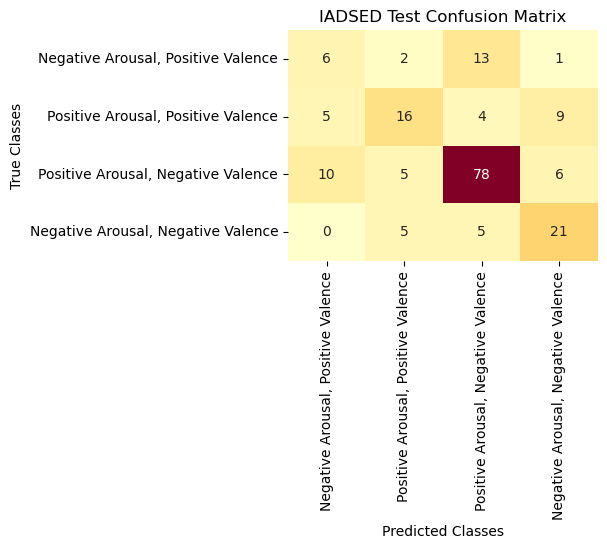

In [22]:
RFClassification(df_iad, grid_search=True, param_grid=param_grid, ds_balancing=True, ds_name="IADSED")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.13      0.21        23
Negative Arousal, Positive Valence       0.62      0.92      0.74        37
Positive Arousal, Negative Valence       0.76      0.81      0.79        54
Positive Arousal, Positive Valence       1.00      0.17      0.29         6

                          accuracy                           0.68       120
                         macro avg       0.72      0.51      0.50       120
                      weighted avg       0.68      0.68      0.64       120



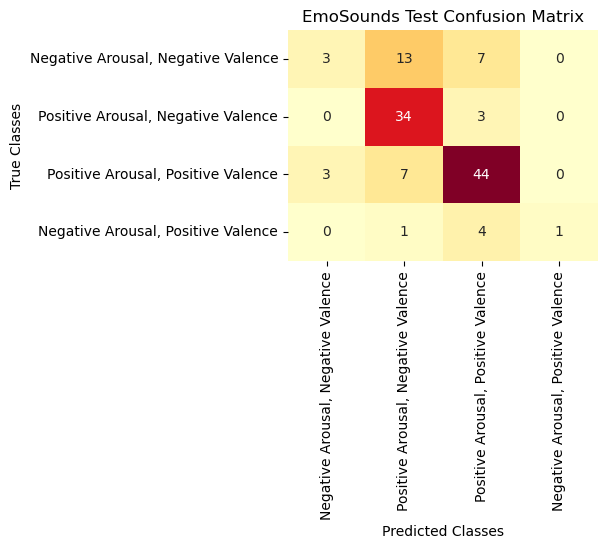

In [23]:
RFClassification(df_emo, grid_search=True, param_grid=param_grid, ds_balancing=True, ds_name="EmoSounds")

# Grid Search CV (Feature Selection and Dataset Balancing)

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.27      0.30        22
Negative Arousal, Positive Valence       0.70      0.47      0.56        34
Positive Arousal, Negative Valence       0.79      0.86      0.83        99
Positive Arousal, Positive Valence       0.55      0.68      0.61        31

                          accuracy                           0.69       186
                         macro avg       0.59      0.57      0.57       186
                      weighted avg       0.68      0.69      0.68       186



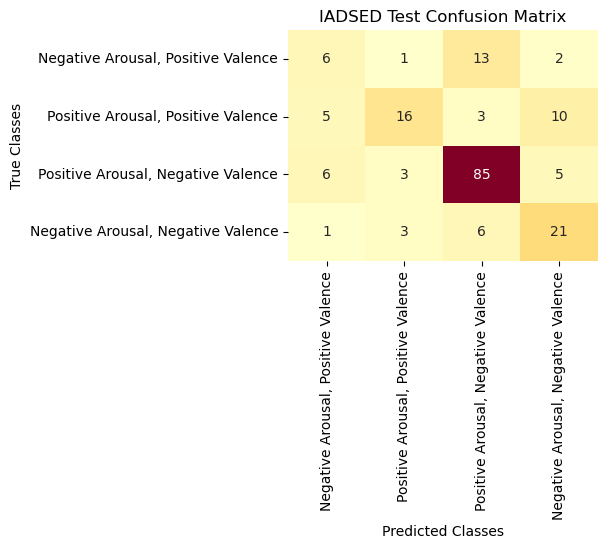

In [24]:
RFClassification(df_iad, grid_search=True, param_grid=param_grid, feature_selection=True, ds_balancing=True, ds_name="IADSED")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.78      0.30      0.44        23
Negative Arousal, Positive Valence       0.60      0.81      0.69        37
Positive Arousal, Negative Valence       0.79      0.76      0.77        54
Positive Arousal, Positive Valence       0.11      0.17      0.13         6

                          accuracy                           0.66       120
                         macro avg       0.57      0.51      0.51       120
                      weighted avg       0.69      0.66      0.65       120



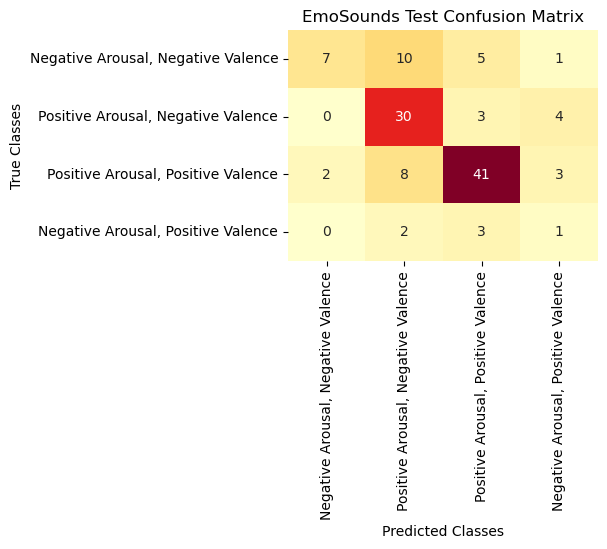

In [25]:
RFClassification(df_emo, grid_search=True, param_grid=param_grid, feature_selection=True, ds_balancing=True, ds_name="EmoSounds")